<a href="https://colab.research.google.com/github/erdemtaskiran/Mart/blob/main/MART_Study_ipynb_adl%C4%B1_not_defterinin_kopyas%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.transforms as transforms
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt

# BLIP-2 Model
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")

# Load Painting Image (This is the painting we ll show in the museum)
image_path = "/content/sd.jpg"
image = Image.open(image_path).convert("RGB")

# Generate Caption with Token Limit
inputs = processor(image, return_tensors="pt")
caption_ids = model.generate(**inputs, max_length=15)  # Limit description to 15 tokens
baseline_description = processor.decode(caption_ids[0], skip_special_tokens=True)

# Print and Save the Description
print("Generated Baseline Description:", baseline_description)

# Save to file for further analysis
with open("baseline_description.txt", "w") as f:
    f.write(baseline_description)

print

Generated Baseline Description: painting of a road in a forest with blue trees and a sunset


<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [ ]:
# Step 1: Load Participant Sentences (This is totally AI generated descriptions I made)
df = pd.read_csv("/content/participant_sentences_painting.csv")

#Step 2: Generate AI Baseline Descriptions; very simple description created by Vision model for one painting as a basline measurment
baseline_english = baseline_description

#Step 3: Load Multilingual Embedding Model
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

#Step 4: Compute Sentence Embeddings
# Generate baseline embeddings
baseline_embedding_en = model.encode([baseline_english])
# Generate participant embeddings
df["Embedding"] = df["Sentence"].apply(lambda x: model.encode([x]))

# Step 5: Compute Semantic Complexity (Cosine Distance)
df["Semantic_Complexity"] = df["Embedding"].apply(lambda x: 1 - cosine_similarity(x.reshape(1, -1), baseline_embedding_en)[0, 0])



In [ ]:
print(baseline_english)


painting of a road in a forest with blue trees and a sunset


One-way ANOVA results:
F-statistic: 15.6963
p-value: 0.0000

Group summary statistics:
       count      mean       std       sem
Group                                     
1         15  0.586087  0.072919  0.018828
2         15  0.639668  0.125856  0.032496
3         15  0.431906  0.110447  0.028517


<ipython-input-17-b072a11a466b>:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = data.groupby('Group')['Semantic_Complexity'].agg(['count', 'mean', 'std'])



Tukey's HSD post-hoc test:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2   0.0536 0.3544   -0.04  0.1471  False
     1      3  -0.1542 0.0007 -0.2477 -0.0606   True
     2      3  -0.2078    0.0 -0.3013 -0.1142   True
----------------------------------------------------

Tukey's test results in table format:
   group1  group2  meandiff   p-adj   lower   upper  reject
0       1       2    0.0536  0.3544 -0.0400  0.1471   False
1       1       3   -0.1542  0.0007 -0.2477 -0.0606    True
2       2       3   -0.2078  0.0000 -0.3013 -0.1142    True


<ipython-input-17-b072a11a466b>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  ax = sns.barplot(x='Group', y='Semantic_Complexity', data=data,
<ipython-input-17-b072a11a466b>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Group', y='Semantic_Complexity', data=data,
<ipython-input-17-b072a11a466b>:38: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  ax = sns.barplot(x='Group', y='Semantic_Complexity', data=data,
<ipython-input-17-b072a11a466b>:134: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{group_descriptions[str(int(float(label.get_text())))]}\n(Group {label.get_text()})"


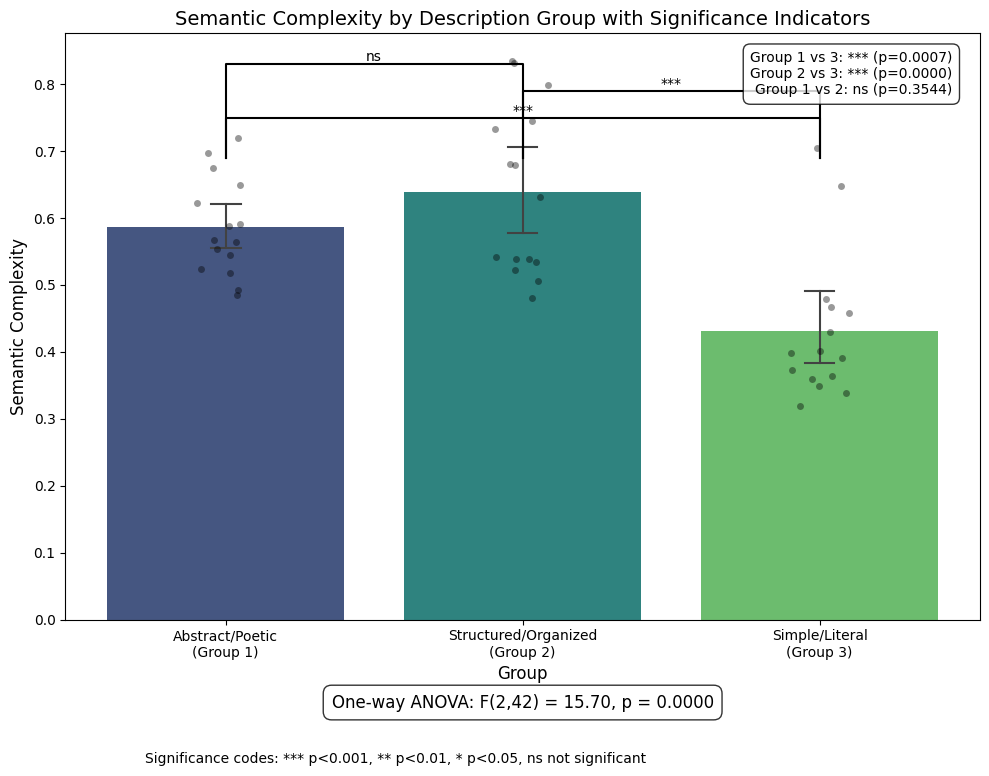

In [ ]:
data = pd.read_csv('/content/semantic_complexity_results.csv')

data['Group'] = data['Group'].astype('category')

# One-way ANOVA
groups = [data[data['Group'] == group]['Semantic_Complexity'] for group in [1, 2, 3]]
f_statistic, p_value = stats.f_oneway(*groups)

print(f"One-way ANOVA results:")
print(f"F-statistic: {f_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

summary = data.groupby('Group')['Semantic_Complexity'].agg(['count', 'mean', 'std'])
summary['sem'] = summary['std'] / np.sqrt(summary['count'])
print("\nGroup summary statistics:")
print(summary)

# Post-Hoc
tukey = pairwise_tukeyhsd(data['Semantic_Complexity'], data['Group'], alpha=0.05)
print("\nTukey's HSD post-hoc test:")
print(tukey)

tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
print("\nTukey's test results in table format:")
print(tukey_df)

plt.figure(figsize=(10, 8))

# Create the barplot
ax = sns.barplot(x='Group', y='Semantic_Complexity', data=data,
                palette='viridis', capsize=0.1, errwidth=1.5, ci=95)

# Add individual data points
sns.stripplot(x='Group', y='Semantic_Complexity', data=data,
              color='black', jitter=True, alpha=0.4, size=5, ax=ax)

bars = ax.patches
bar_positions = np.array([bar.get_x() + bar.get_width() / 2 for bar in bars[:3]])
bar_heights = np.array([bar.get_height() for bar in bars[:3]])

def add_significance_bar(ax, x1, x2, y, h, text):
    trans = transforms.blended_transform_factory(ax.transData, ax.transData)
    line_h = h
    bar_height = y + line_h

    ax.plot([x1, x1, x2, x2], [y, bar_height, bar_height, y], 'k', linewidth=1.5, transform=trans)

    ax.text((x1 + x2) / 2, bar_height, text, ha='center', va='bottom', transform=trans)

comparisons = {}
for i, row in tukey_df.iterrows():
    group1, group2 = row['group1'], row['group2']
    reject = row['reject']
    p_value = row['p-adj']

    key = f"{group1}-{group2}"
    comparisons[key] = (reject, p_value)

max_bar_height = max(bar_heights) + 0.05
line_heights = [0.06, 0.10, 0.14]

significances = []

def get_significance_symbol(p_value):
    if p_value < 0.001:
        return "***"
    elif p_value < 0.01:
        return "**"
    elif p_value < 0.05:
        return "*"
    else:
        return "ns"

reject_1_3, p_1_3 = comparisons.get('1-3', (False, 1.0))
symbol_1_3 = get_significance_symbol(p_1_3)
add_significance_bar(ax, bar_positions[0], bar_positions[2], max_bar_height, line_heights[0], symbol_1_3)
significances.append(f"Group 1 vs 3: {symbol_1_3} (p={p_1_3:.4f})")

reject_2_3, p_2_3 = comparisons.get('2-3', (False, 1.0))
symbol_2_3 = get_significance_symbol(p_2_3)
add_significance_bar(ax, bar_positions[1], bar_positions[2], max_bar_height, line_heights[1], symbol_2_3)
significances.append(f"Group 2 vs 3: {symbol_2_3} (p={p_2_3:.4f})")

reject_1_2, p_1_2 = comparisons.get('1-2', (False, 1.0))
symbol_1_2 = get_significance_symbol(p_1_2)
add_significance_bar(ax, bar_positions[0], bar_positions[1], max_bar_height, line_heights[2], symbol_1_2)
significances.append(f"Group 1 vs 2: {symbol_1_2} (p={p_1_2:.4f})")

plt.text(0.5, -0.15,
        f"One-way ANOVA: F({len(groups)-1},{sum([len(g) for g in groups])-len(groups)}) = {f_statistic:.2f}, p = {p_value:.4f}",
        ha='center', transform=ax.transAxes, fontsize=12,
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

significance_text = "\n".join(significances)
plt.text(0.97, 0.97, significance_text,
        ha='right', va='top', transform=ax.transAxes, fontsize=10,
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

plt.title('Semantic Complexity by Description Group with Significance Indicators', fontsize=14)
plt.xlabel('Group', fontsize=12)
plt.ylabel('Semantic Complexity', fontsize=12)

group_descriptions = {
    '1': 'Abstract/Poetic',
    '2': 'Structured/Organized',
    '3': 'Simple/Literal'
}

ax.set_xticklabels([f"{group_descriptions[str(int(float(label.get_text())))]}\n(Group {label.get_text()})"
                   for label in ax.get_xticklabels()])

plt.figtext(0.15, 0.01,
           "Significance codes: *** p<0.001, ** p<0.01, * p<0.05, ns not significant",
           ha='left', fontsize=10)

plt.tight_layout(rect=[0, 0.05, 1, 0.97])

plt.show()